# TFGAN Tutorial

## Authors: Joel Shor, joel-shor

### More complex examples, see [`tensorflow/models/gan`](https://github.com/tensorflow/models/tree/master/research/gan)


This notebook will walk you through the basics of using [TFGAN](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/gan) to define, train, and evaluate Generative Adversarial Networks. We describe the library's core features as well as some extra features. This colab assumes a familiarity with TensorFlow's Python API. For more on TensorFlow, please see [TensorFlow tutorials](https://www.tensorflow.org/tutorials/).

Please note that running on GPU will significantly speed up the training steps, but is not required.

Last update: 2017-10-16.

## Table of Contents
<a href='#installation_and_setup'>Installation and Setup</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#download_data'>Download Data</a><br>
<a href='#unconditional_example'>Unconditional GAN example</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#unconditional_input'>Input pipeline</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#unconditional_model'>Model</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#unconditional_loss'>Loss</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#unconditional_train'>Train and evaluation</a><br>
<a href='#ganestimator_example'>GANEstimator example</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#ganestimator_input'>Input pipeline</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#ganestimator_train'>Train</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#ganestimator_eval'>Eval</a><br>
<a href='#conditional_example'>Conditional GAN example</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#conditional_input'>Input pipeline</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#conditional_model'>Model</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#conditional_loss'>Loss</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#conditional_train'>Train and evaluation</a><br>
<a href='#infogan_example'>InfoGAN example</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#infogan_input'>Input pipeline</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#infogan_model'>Model</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#infogan_loss'>Loss</a><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href='#infogan_train'>Train and evaluation</a><br>

<a id='installation_and_setup'></a>
## Installation and setup

To make sure that your version of TensorFlow has TFGAN included, run

```
python -c "import tensorflow.contrib.gan as tfgan"
```

You also need to install the TFGAN models library and the TF-Slim models library.

To check that these two steps work, execute the [`Imports`](#imports) cell. If it complains about unknown modules, restart the notebook after moving to the TFGAN models directory.

In [1]:
# Make TFGAN models and TF-Slim models discoverable.
import sys
import os
# This is needed since the notebook is stored in the `tensorflow/models/gan` folder.
sys.path.append('..')
sys.path.append(os.path.join('..', 'slim'))

<a id='imports'></a>
### Imports

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import functools

import tensorflow as tf

# Main TFGAN library.
tfgan = tf.contrib.gan

# TFGAN MNIST examples from `tensorflow/models`.
from mnist import data_provider
from mnist import util

# TF-Slim data provider.
from datasets import download_and_convert_mnist

# Shortcuts for later.
slim = tf.contrib.slim
layers = tf.contrib.layers
ds = tf.contrib.distributions

### Common functions

These functions are used by many examples, so we define them here.

In [3]:
leaky_relu = lambda net: tf.nn.leaky_relu(net, alpha=0.01)
  

def visualize_training_generator(train_step_num, start_time, data_np):
    """Visualize generator outputs during training.
    
    Args:
        train_step_num: The training step number. A python integer.
        start_time: Time when training started. The output of `time.time()`. A
            python float.
        data: Data to plot. A numpy array, most likely from an evaluated TensorFlow
            tensor.
    """
    print('Training step: %i' % train_step_num)
    time_since_start = (time.time() - start_time) / 60.0
    print('Time since start: %f m' % time_since_start)
    print('Steps per min: %f' % (train_step_num / time_since_start))
    plt.axis('off')
    plt.imshow(np.squeeze(data_np), cmap='gray')
    plt.show()

def visualize_digits(tensor_to_visualize):
    """Visualize an image once. Used to visualize generator before training.
    
    Args:
        tensor_to_visualize: An image tensor to visualize. A python Tensor.
    """
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        with slim.queues.QueueRunners(sess):
            images_np = sess.run(tensor_to_visualize)
    plt.axis('off')
    plt.imshow(np.squeeze(images_np), cmap='gray')
    return images_np

def evaluate_tfgan_loss(gan_loss, name=None):
    """Evaluate GAN losses. Used to check that the graph is correct.
    
    Args:
        gan_loss: A GANLoss tuple.
        name: Optional. If present, append to debug output.
    """
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        with slim.queues.QueueRunners(sess):
            gen_loss_np = sess.run(gan_loss.generator_loss)
            dis_loss_np = sess.run(gan_loss.discriminator_loss)
    if name:
        print('%s generator loss: %f' % (name, gen_loss_np))
        print('%s discriminator loss: %f'% (name, dis_loss_np))
    else:
        print('Generator loss: %f' % gen_loss_np)
        print('Discriminator loss: %f'% dis_loss_np)

<a id='download_data'></a>
### Download data

In [4]:
MNIST_DATA_DIR = '/tmp/mnist-data'

In [5]:

if not tf.gfile.Exists(MNIST_DATA_DIR):
    tf.gfile.MakeDirs(MNIST_DATA_DIR)

download_and_convert_mnist.run(MNIST_DATA_DIR)

>> Downloading 100.1%
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
>> Downloading 113.5%
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
>> Downloading 100.4%
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
>> Downloading 180.4%
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting images from:  /tmp/mnist-data/train-images-idx3-ubyte.gz
Extracting labels from:  /tmp/mnist-data/train-labels-idx1-ubyte.gz
>> Converting image 2976/60000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



>> Converting image 7832/60000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



>> Converting image 12486/60000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



>> Converting image 17300/60000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



>> Converting image 21997/60000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



>> Converting image 26592/60000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



>> Converting image 31268/60000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



>> Converting image 35803/60000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



>> Converting image 40364/60000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



>> Converting image 44836/60000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



>> Converting image 49311/60000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



>> Converting image 54170/60000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



>> Converting image 59026/60000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



>> Converting image 3939/10000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



>> Converting image 9059/10000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



<a id='unconditional_example'></a>
# Unconditional GAN Example

With unconditional GANs, we want a generator network to produce realistic-looking digits. During training, the generator tries to produce realistic-enough digits to 'fool' a discriminator network, while the discriminator tries to distinguish real digits from generated ones. See the paper ['NIPS 2016 Tutorial: Generative Adversarial Networks'](https://arxiv.org/pdf/1701.00160.pdf) by Goodfellow or ['Generative Adversarial Networks'](https://arxiv.org/abs/1406.2661) by Goodfellow et al. for more details.

The steps to using TFGAN to set up an unconditional GAN, in the simplest case, are as follows:

1. **Model**: Set up the generator and discriminator graphs with a [`GANModel`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/namedtuples.py#L39) tuple. Use [`tfgan.gan_model`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/train.py#L64) or create one manually.
1. **Losses**: Set up the generator and discriminator losses with a [`GANLoss`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/namedtuples.py#L115) tuple. Use [`tfgan.gan_loss`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/train.py#L328) or create one manually.
1. **Train ops**: Set up TensorFlow ops that compute the loss, calculate the gradients, and update the weights with a [`GANTrainOps`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/namedtuples.py#L128) tuple. Use [`tfgan.gan_train_ops`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/train.py#L476) or create one manually.
1. **Run alternating train loop**: Run the training Ops. This can be done with [`tfgan.gan_train`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/train.py#L661), or done manually.

Each step can be performed by a TFGAN library call, or can be constructed manually for more control.

<a id='unconditional_input'></a>
## Data input pipeline

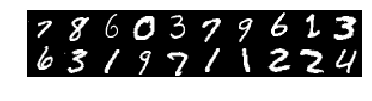

In [6]:
tf.reset_default_graph()

# Define our input pipeline. Pin it to the CPU so that the GPU can be reserved
# for forward and backwards propogation.
batch_size = 32
with tf.device('/cpu:0'):
    images, _, _ = data_provider.provide_data('train', batch_size, MNIST_DATA_DIR)

#images.shape, TensorShape([Dimension(32), Dimension(28), Dimension(28), Dimension(1)])
imgs_to_visualize = tfgan.eval.image_reshaper(images[:20,...], num_cols=10)
# imgs_to_visualize.shape, TensorShape([Dimension(1), Dimension(56), Dimension(280), Dimension(1)])
images = visualize_digits(imgs_to_visualize)


<a id='unconditional_model'></a>
## Model

Set up a [GANModel tuple](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/namedtuples.py#L39), which defines everything we need to perform GAN training. You can create the tuple with the library functions, or you can manually create one.

Define the GANModel tuple using the TFGAN library function.
For the simplest case, we need the following:

1. A generator function that takes input noise and outputs generated MNIST digits

1. A discriminator function that takes images and outputs a probability of  being real or fake

1. Real images

1. A noise vector to pass to the generator

### Generator

In [7]:
def generator_fn(noise, weight_decay=2.5e-5):
    """Simple generator to produce MNIST images.
    
    Args:
        noise: A single Tensor representing noise.
        weight_decay: The value of the l2 weight decay.
    
    Returns:
        A generated image in the range [-1, 1].
    """
    with slim.arg_scope(
        [layers.fully_connected, layers.conv2d_transpose],
        activation_fn=tf.nn.relu, normalizer_fn=layers.batch_norm,
        weights_regularizer=layers.l2_regularizer(weight_decay)):
        net = layers.fully_connected(noise, 1024)
        net = layers.fully_connected(net, 7 * 7 * 256)
        net = tf.reshape(net, [-1, 7, 7, 256])
        net = layers.conv2d_transpose(net, 64, [4, 4], stride=2)
        net = layers.conv2d_transpose(net, 32, [4, 4], stride=2)
        # Make sure that generator output is in the same range as `inputs`
        # ie [-1, 1].
        net = layers.conv2d(net, 1, 4, normalizer_fn=None, activation_fn=tf.tanh)
        
        return net

### Discriminator

In [8]:
def discriminator_fn(img, unused_conditioning, weight_decay=2.5e-5):
    """Discriminator network on MNIST digits.
    
    Args:
        img: Real or generated MNIST digits. Should be in the range [-1, 1].
        unused_conditioning: The TFGAN API can help with conditional GANs, which
            would require extra `condition` information to both the generator and the
            discriminator. Since this example is not conditional, we do not use this
            argument.
        weight_decay: The L2 weight decay.
    
    Returns:
        Logits for the probability that the image is real.
    """
    with slim.arg_scope(
        [layers.conv2d, layers.fully_connected],
        activation_fn=leaky_relu, normalizer_fn=None,
        weights_regularizer=layers.l2_regularizer(weight_decay),
        biases_regularizer=layers.l2_regularizer(weight_decay)):
        net = layers.conv2d(img, 64, [4, 4], stride=2)
        net = layers.conv2d(net, 128, [4, 4], stride=2)
        net = layers.flatten(net)
        net = layers.fully_connected(net, 1024, normalizer_fn=layers.batch_norm)
        return layers.linear(net, 1)

In [9]:
help(tfgan.gan_model)

Help on function gan_model in module tensorflow.contrib.gan.python.train:

gan_model(generator_fn, discriminator_fn, real_data, generator_inputs, generator_scope='Generator', discriminator_scope='Discriminator', check_shapes=True)
    Returns GAN model outputs and variables.
    
    Args:
      generator_fn: A python lambda that takes `generator_inputs` as inputs and
        returns the outputs of the GAN generator.
      discriminator_fn: A python lambda that takes `real_data`/`generated data`
        and `generator_inputs`. Outputs a Tensor in the range [-inf, inf].
      real_data: A Tensor representing the real data.
      generator_inputs: A Tensor or list of Tensors to the generator. In the
        vanilla GAN case, this might be a single noise Tensor. In the conditional
        GAN case, this might be the generator's conditioning.
      generator_scope: Optional generator variable scope. Useful if you want to
        reuse a subgraph that has already been created.
      discrim

### GANModel Tuple

In [10]:
tf.reset_default_graph()
noise_dims = 64
gan_model = tfgan.gan_model(
    generator_fn,
    discriminator_fn,
    real_data=images,
    generator_inputs=tf.random_normal([batch_size, noise_dims]))

# Sanity check that generated images before training are garbage.
generated_data_to_visualize = tfgan.eval.image_reshaper(
    gan_model.generated_data[:20,...], num_cols=10)
visualize_digits(generated_data_to_visualize)

ValueError: Trying to share variable Discriminator/fully_connected/weights, but specified shape (125440, 1024) and found shape (6272, 1024).

<a id='unconditional_loss'></a>
## Losses

We next set up the GAN model losses.

Loss functions are currently an active area of research. The [losses library](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/losses/python/losses_impl.py) provides some well-known or successful loss functions, such as the [original minimax](https://arxiv.org/abs/1406.2661), [Wasserstein](https://arxiv.org/abs/1701.07875) (by Arjovsky et al), and [improved Wasserstein](https://arxiv.org/abs/1704.00028) (by Gulrajani et al) losses. It is easy to add loss functions to the library as they are developed, and you can also pass in a custom loss function.

In [ ]:
# We can use the minimax loss from the original paper.
vanilla_gan_loss = tfgan.gan_loss(
    gan_model,
    generator_loss_fn=tfgan.losses.minimax_generator_loss,
    discriminator_loss_fn=tfgan.losses.minimax_discriminator_loss)

# We can use the Wasserstein loss (https://arxiv.org/abs/1701.07875) with the 
# gradient penalty from the improved Wasserstein loss paper 
# (https://arxiv.org/abs/1704.00028).
improved_wgan_loss = tfgan.gan_loss(
    gan_model,
    # We make the loss explicit for demonstration, even though the default is 
    # Wasserstein loss.
    generator_loss_fn=tfgan.losses.wasserstein_generator_loss,
    discriminator_loss_fn=tfgan.losses.wasserstein_discriminator_loss,
    gradient_penalty_weight=1.0)

# We can also define custom losses to use with the rest of the TFGAN framework.
def silly_custom_generator_loss(gan_model, add_summaries=False):
    return tf.reduce_mean(gan_model.discriminator_gen_outputs)
def silly_custom_discriminator_loss(gan_model, add_summaries=False):
    return (tf.reduce_mean(gan_model.discriminator_gen_outputs) -
            tf.reduce_mean(gan_model.discriminator_real_outputs))
custom_gan_loss = tfgan.gan_loss(
    gan_model,
    generator_loss_fn=silly_custom_generator_loss,
    discriminator_loss_fn=silly_custom_discriminator_loss)

# Sanity check that we can evaluate our losses.
for gan_loss, name in [(vanilla_gan_loss, 'vanilla loss'), 
                       (improved_wgan_loss, 'improved wgan loss'), 
                       (custom_gan_loss, 'custom loss')]:
    evaluate_tfgan_loss(gan_loss, name)

<a id='unconditional_train'></a>
## Training and Evaluation

### Train Ops
In order to train a GAN, we need to train both generator and discriminator networks using some variant of the alternating training paradigm. To do this, we construct a [GANTrainOps tuple](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/namedtuples.py#L128) either manually or with a library call. We pass it the optimizers that we want to use, as well as any extra arguments that we'd like passed to slim's `create_train_op` function.

In [ ]:
generator_optimizer = tf.train.AdamOptimizer(0.001, beta1=0.5)
discriminator_optimizer = tf.train.AdamOptimizer(0.0001, beta1=0.5)
gan_train_ops = tfgan.gan_train_ops(
    gan_model,
    improved_wgan_loss,
    generator_optimizer,
    discriminator_optimizer)

### Evaluation

TFGAN provides some standard methods of evaluating generative models. In this example, we use a pre-trained classifier to calculate what is called the 'Inception Score' from [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) (by Salimans et al). This metric is a combined score of quality and diversity.

In [ ]:
num_images_to_eval = 500
MNIST_CLASSIFIER_FROZEN_GRAPH = './mnist/data/classify_mnist_graph_def.pb'

# For variables to load, use the same variable scope as in the train job.
with tf.variable_scope('Generator', reuse=True):
    eval_images = gan_model.generator_fn(
        tf.random_normal([num_images_to_eval, noise_dims]))

eval_score = util.mnist_score(eval_images, MNIST_CLASSIFIER_FROZEN_GRAPH)

### Train Steps

Now we're ready to train. TFGAN handles the alternating training scheme that arises from the GAN minmax game. It also gives you the option of changing the ratio of discriminator updates to generator updates. Most applications (distributed setting, borg, etc) will use the [`gan_train`](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/train.py#L661) function, but we will use a different TFGAN utility and manually run the train ops so we can introspect more.

This code block should take about **1 minute** to run on a GPU kernel, and about **5 minutes** on CPU.

In [ ]:
# We have the option to train the discriminator more than one step for every 
# step of the generator. In order to do this, we use a `GANTrainSteps` with 
# desired values. For this example, we use the default 1 generator train step 
# for every discriminator train step.
train_step_fn = tfgan.get_sequential_train_steps()

global_step = tf.train.get_or_create_global_step()
loss_values, mnist_score_values  = [], []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    with slim.queues.QueueRunners(sess):
        start_time = time.time()
        for i in range(801):
            cur_loss, _ = train_step_fn(
                sess, gan_train_ops, global_step, train_step_kwargs={})
            loss_values.append((i, cur_loss))
            if i % 100 == 0:
                mnist_score_values.append((i, sess.run(eval_score)))
            if i % 200 == 0:
                print('Current loss: %f' % cur_loss)
                print('Current MNIST score: %f' % mnist_score_values[-1][1])
                visualize_training_generator(
                    i, start_time, sess.run(generated_data_to_visualize))

In [ ]:
# Plot the eval metrics over time.
plt.title('MNIST Score per step')
plt.plot(*zip(*mnist_score_values))
plt.figure()
plt.title('Training loss per step')
plt.plot(*zip(*loss_values))
plt.show()

<a id='ganestimator_example'></a>
# GANEstimator
TensorFlow offers a tf.Estimators API that makes it easy to train models. TFGAN offers a tf.Estimators compatible `GANEstimator`.

<a id='ganestimator_input'></a>
## Data input pipeline
`tf.Estimators` use `input_fn` to pass data to the estimators. We need one data source for training and one for inference.

In [ ]:
tf.reset_default_graph()

def _get_train_input_fn(batch_size, noise_dims):
    def train_input_fn():
        with tf.device('/cpu:0'):
            images, _, _ = data_provider.provide_data(
                'train', batch_size, MNIST_DATA_DIR)
        noise = tf.random_normal([batch_size, noise_dims])
        return noise, images
    return train_input_fn


def _get_predict_input_fn(batch_size, noise_dims):
    def predict_input_fn():
        noise = tf.random_normal([batch_size, noise_dims])
        return noise
    return predict_input_fn

<a id='ganestimator_train'></a>
## Training
Training with `tf.Estimators` is easy.

In [ ]:
BATCH_SIZE = 32
NOISE_DIMS = 64
NUM_STEPS = 2000

# Initialize GANEstimator with options and hyperparameters.
gan_estimator = tfgan.estimator.GANEstimator(
    generator_fn=generator_fn,  # Same as before.
    discriminator_fn=discriminator_fn,  # Same as before.
    generator_loss_fn=tfgan.losses.wasserstein_generator_loss,
    discriminator_loss_fn=tfgan.losses.wasserstein_discriminator_loss,
    generator_optimizer=tf.train.AdamOptimizer(0.001, 0.5),
    discriminator_optimizer=tf.train.AdamOptimizer(0.0001, 0.5),
    add_summaries=tfgan.estimator.SummaryType.IMAGES)

# Train estimator.
train_input_fn = _get_train_input_fn(BATCH_SIZE, NOISE_DIMS)
gan_estimator.train(train_input_fn, max_steps=NUM_STEPS)

<a id='ganestimator_eval'></a>
## Evaluation
Visualize some sample images.

In [ ]:
# Run inference.
predict_input_fn = _get_predict_input_fn(36, NOISE_DIMS)
prediction_iterable = gan_estimator.predict(predict_input_fn)
predictions = [prediction_iterable.next() for _ in range(36)]

# Nicely tile output and visualize.
image_rows = [np.concatenate(predictions[i:i+6], axis=0) for i in
              range(0, 36, 6)]
tiled_images = np.concatenate(image_rows, axis=1)

# Visualize.
plt.axis('off')
plt.imshow(np.squeeze(tiled_images), cmap='gray')

<a id='conditional_example'></a>
# Conditional GAN Example

In the conditional GAN setting on MNIST, we wish to train a generator to produce
realistic-looking digits **of a particular type**. For example, we want to be able to produce as many '3's as we want without producing other digits. In contrast, in the unconditional case, we have no control over what digit the generator produces. In order to train a conditional generator, we pass the digit's identity to the generator and discriminator in addition to the noise vector. See [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784) by Mirza and Osindero for more details.

<a id='conditional_input'></a>

## Data input pipeline

array([[[[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        ...,

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]]]], dtype=float32)

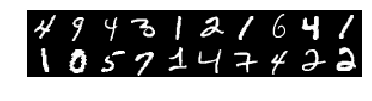

In [6]:
tf.reset_default_graph()

# Define our input pipeline. Pin it to the CPU so that the GPU can be reserved
# for forward and backwards propogation.
batch_size = 32
with tf.device('/cpu:0'):
    images, one_hot_labels, _ = data_provider.provide_data('train', batch_size, MNIST_DATA_DIR)

# Sanity check that we're getting images.
imgs_to_visualize = tfgan.eval.image_reshaper(images[:20,...], num_cols=10)
visualize_digits(imgs_to_visualize)

<a id='conditional_model'></a>
## Model

We perform the same procedure as in the unconditional case, but pass the digit label to the generator and discriminator as well as a random noise vector.

### Generator

In [7]:
def conditional_generator_fn(inputs, weight_decay=2.5e-5):
    """Generator to produce MNIST images.
    
    Args:
        inputs: A 2-tuple of Tensors (noise, one_hot_labels).
        weight_decay: The value of the l2 weight decay.

    Returns:
        A generated image in the range [-1, 1].
    """
    noise, one_hot_labels = inputs
  
    with slim.arg_scope(
        [layers.fully_connected, layers.conv2d_transpose],
        activation_fn=tf.nn.relu, normalizer_fn=layers.batch_norm,
        weights_regularizer=layers.l2_regularizer(weight_decay)):
        net = layers.fully_connected(noise, 1024)
        net = tfgan.features.condition_tensor_from_onehot(net, one_hot_labels)
        net = layers.fully_connected(net, 7 * 7 * 128)
        net = tf.reshape(net, [-1, 7, 7, 128])
        net = layers.conv2d_transpose(net, 64, [4, 4], stride=2)
        net = layers.conv2d_transpose(net, 32, [4, 4], stride=2)
        # Make sure that generator output is in the same range as `inputs`
        # ie [-1, 1].
        net = layers.conv2d(net, 1, 4, normalizer_fn=None, activation_fn=tf.tanh)

        return net

### Discriminator

In [8]:
def conditional_discriminator_fn(img, conditioning, weight_decay=2.5e-5):
    """Conditional discriminator network on MNIST digits.
    
    Args:
        img: Real or generated MNIST digits. Should be in the range [-1, 1].
        conditioning: A 2-tuple of Tensors representing (noise, one_hot_labels).
        weight_decay: The L2 weight decay.

    Returns:
        Logits for the probability that the image is real.
    """
    _, one_hot_labels = conditioning
    with slim.arg_scope(
        [layers.conv2d, layers.fully_connected],
        activation_fn=leaky_relu, normalizer_fn=None,
        weights_regularizer=layers.l2_regularizer(weight_decay),
        biases_regularizer=layers.l2_regularizer(weight_decay)):
        net = layers.conv2d(img, 64, [4, 4], stride=2)
        net = layers.conv2d(net, 128, [4, 4], stride=2)
        net = layers.flatten(net)
        net = tfgan.features.condition_tensor_from_onehot(net, one_hot_labels)
        net = layers.fully_connected(net, 1024, normalizer_fn=layers.batch_norm)
        
        return layers.linear(net, 1)

### GANModel Tuple

array([[[[ 1.5451423e-02],
         [ 2.8841954e-01],
         [-1.2825276e-01],
         ...,
         [-2.3122386e-03],
         [ 2.1506923e-01],
         [ 8.6817980e-02]],

        [[-4.3907473e-03],
         [-2.8215855e-01],
         [-2.2470621e-02],
         ...,
         [-4.1097182e-01],
         [-7.5310403e-01],
         [ 4.7345497e-02]],

        [[ 2.0368959e-01],
         [-3.4681734e-01],
         [-8.9907432e-01],
         ...,
         [ 6.9160968e-02],
         [-7.3564035e-01],
         [-6.4979666e-01]],

        ...,

        [[-7.4879211e-01],
         [-4.1455276e-02],
         [ 3.5594080e-02],
         ...,
         [-1.5810068e-01],
         [-5.4583758e-01],
         [ 2.9882559e-01]],

        [[-1.4500980e-01],
         [ 3.0340757e-02],
         [-9.5009243e-01],
         ...,
         [-8.0268368e-02],
         [-4.8380479e-01],
         [-4.7820112e-01]],

        [[ 7.3462701e-04],
         [-4.0713269e-01],
         [-4.5032072e-01],
         ...,
 

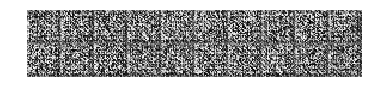

In [9]:
noise_dims = 64
conditional_gan_model = tfgan.gan_model(
    generator_fn=conditional_generator_fn,
    discriminator_fn=conditional_discriminator_fn,
    real_data=images,
    generator_inputs=(tf.random_normal([batch_size, noise_dims]), 
                      one_hot_labels))

# Sanity check that currently generated images are garbage.
cond_generated_data_to_visualize = tfgan.eval.image_reshaper(
    conditional_gan_model.generated_data[:20,...], num_cols=10)
visualize_digits(cond_generated_data_to_visualize)

<a id='conditional_loss'></a>
## Losses

In [ ]:
gan_loss = tfgan.gan_loss(
    conditional_gan_model, gradient_penalty_weight=1.0)

# Sanity check that we can evaluate our losses.
evaluate_tfgan_loss(gan_loss)

<a id='conditional_train'></a>
## Training and Evaluation


We use a slightly different learning rate schedule that involves decay.

### Train Ops

In [ ]:
generator_optimizer = tf.train.AdamOptimizer(0.0009, beta1=0.5)
discriminator_optimizer = tf.train.AdamOptimizer(0.00009, beta1=0.5)
gan_train_ops = tfgan.gan_train_ops(
    conditional_gan_model,
    gan_loss,
    generator_optimizer,
    discriminator_optimizer)

### Evaluation

Since quantitative metrics for generators are sometimes tricky (see [A note on the evaluation of generative models](https://arxiv.org/abs/1511.01844) for some surprising ones), we also want to visualize our progress.

In [ ]:
# Set up class-conditional visualization. We feed class labels to the generator
# so that the the first column is `0`, the second column is `1`, etc.
images_to_eval = 500
assert images_to_eval % 10 == 0

random_noise = tf.random_normal([images_to_eval, 64])
one_hot_labels = tf.one_hot(
    [i for _ in xrange(images_to_eval // 10) for i in xrange(10)], depth=10) 
with tf.variable_scope(conditional_gan_model.generator_scope, reuse=True):
    eval_images = conditional_gan_model.generator_fn(
        (random_noise, one_hot_labels))
reshaped_eval_imgs = tfgan.eval.image_reshaper(
    eval_images[:20, ...], num_cols=10)

# We will use a pretrained classifier to measure the progress of our generator. 
# Specifically, the cross-entropy loss between the generated image and the target 
# label will be the metric we track.
MNIST_CLASSIFIER_FROZEN_GRAPH = './mnist/data/classify_mnist_graph_def.pb'
xent_score = util.mnist_cross_entropy(
    eval_images, one_hot_labels, MNIST_CLASSIFIER_FROZEN_GRAPH)

### Train Steps

In this example, we train the generator and discriminator while keeping track of
our important metric, the cross entropy loss with the real labels.

This code block should take about **2 minutes** on GPU and **10 minutes** on CPU.

In [ ]:
global_step = tf.train.get_or_create_global_step()
train_step_fn = tfgan.get_sequential_train_steps()
loss_values, xent_score_values  = [], []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    with slim.queues.QueueRunners(sess):
        start_time = time.time()
        for i in xrange(2001):
            cur_loss, _ = train_step_fn(
                sess, gan_train_ops, global_step, train_step_kwargs={})
            loss_values.append((i, cur_loss))
            if i % 50 == 0:
                xent_score_values.append((i, sess.run(xent_score)))
            if i % 400 == 0:
                print('Current loss: %f' % cur_loss)
                print('Current cross entropy score: %f' % xent_score_values[-1][1])
                visualize_training_generator(i, start_time, sess.run(reshaped_eval_imgs))

In [ ]:
# Plot the eval metrics over time.
plt.title('Cross entropy score per step')
plt.plot(*zip(*xent_score_values))
plt.figure()
plt.title('Training loss per step')
plt.plot(*zip(*loss_values))
plt.show()

<a id='infogan_example'></a>
# InfoGAN Example

InfoGAN is a technique to induce semantic meaning in the latent space of a GAN generator in an unsupervised way. In this example, the generator learns how to generate a specific digit **without ever seeing labels**. This is achieved by maximizing the mutual information between some subset of the noise vector and the generated images, while also trying to generate realistic images. See [InfoGAN: Interpretable Representation Learning by Information Maximizing Generative Adversarial Nets](https://arxiv.org/abs/1606.03657) by Chen at al for more details.

<a id='infogan_input'></a>
## Data input pipeline

This is the same as the unconditional case (we don't need labels).

In [ ]:
tf.reset_default_graph()

# Define our input pipeline. Pin it to the CPU so that the GPU can be reserved
# for forward and backwards propogation.
batch_size = 32
with tf.device('/cpu:0'):
    images, _, _ = data_provider.provide_data('train', batch_size, MNIST_DATA_DIR)

# Sanity check that we're getting images.
imgs_to_visualize = tfgan.eval.image_reshaper(images[:20,...], num_cols=10)
visualize_digits(imgs_to_visualize)

<a id='infogan_model'></a>
## Model

### Generator

In [ ]:
def infogan_generator(inputs, categorical_dim, weight_decay=2.5e-5):
    """InfoGAN discriminator network on MNIST digits.
    
    Based on a paper https://arxiv.org/abs/1606.03657 and their code
    https://github.com/openai/InfoGAN.
    
    Args:
        inputs: A 3-tuple of Tensors (unstructured_noise, categorical structured
            noise, continuous structured noise). `inputs[0]` and `inputs[2]` must be
            2D, and `inputs[1]` must be 1D. All must have the same first dimension.
        categorical_dim: Dimensions of the incompressible categorical noise.
        weight_decay: The value of the l2 weight decay.
    
    Returns:
        A generated image in the range [-1, 1].
    """
    unstructured_noise, cat_noise, cont_noise = inputs
    cat_noise_onehot = tf.one_hot(cat_noise, categorical_dim)
    all_noise = tf.concat([unstructured_noise, cat_noise_onehot, cont_noise], axis=1)
    
    with slim.arg_scope(
        [layers.fully_connected, layers.conv2d_transpose],
        activation_fn=tf.nn.relu, normalizer_fn=layers.batch_norm,
        weights_regularizer=layers.l2_regularizer(weight_decay)):
        net = layers.fully_connected(all_noise, 1024)
        net = layers.fully_connected(net, 7 * 7 * 128)
        net = tf.reshape(net, [-1, 7, 7, 128])
        net = layers.conv2d_transpose(net, 64, [4, 4], stride=2)
        net = layers.conv2d_transpose(net, 32, [4, 4], stride=2)
        # Make sure that generator output is in the same range as `inputs`
        # ie [-1, 1].
        net = layers.conv2d(net, 1, 4, normalizer_fn=None, activation_fn=tf.tanh)
    
        return net

### Discriminator

In [ ]:
def infogan_discriminator(img, unused_conditioning, weight_decay=2.5e-5,
                          categorical_dim=10, continuous_dim=2):
    """InfoGAN discriminator network on MNIST digits.
    
    Based on a paper https://arxiv.org/abs/1606.03657 and their code
    https://github.com/openai/InfoGAN.
    
    Args:
        img: Real or generated MNIST digits. Should be in the range [-1, 1].
        unused_conditioning: The TFGAN API can help with conditional GANs, which
            would require extra `condition` information to both the generator and the
            discriminator. Since this example is not conditional, we do not use this
            argument.
        weight_decay: The L2 weight decay.
        categorical_dim: Dimensions of the incompressible categorical noise.
        continuous_dim: Dimensions of the incompressible continuous noise.
    
    Returns:
        Logits for the probability that the image is real, and a list of posterior
        distributions for each of the noise vectors.
    """
    with slim.arg_scope(
        [layers.conv2d, layers.fully_connected],
        activation_fn=leaky_relu, normalizer_fn=None,
        weights_regularizer=layers.l2_regularizer(weight_decay),
        biases_regularizer=layers.l2_regularizer(weight_decay)):
        net = layers.conv2d(img, 64, [4, 4], stride=2)
        net = layers.conv2d(net, 128, [4, 4], stride=2)
        net = layers.flatten(net)
        net = layers.fully_connected(net, 1024, normalizer_fn=layers.layer_norm)
    
        logits_real = layers.fully_connected(net, 1, activation_fn=None)

        # Recognition network for latent variables has an additional layer
        encoder = layers.fully_connected(net, 128, normalizer_fn=layers.batch_norm)

        # Compute logits for each category of categorical latent.
        logits_cat = layers.fully_connected(
            encoder, categorical_dim, activation_fn=None)
        q_cat = ds.Categorical(logits_cat)

        # Compute mean for Gaussian posterior of continuous latents.
        mu_cont = layers.fully_connected(
            encoder, continuous_dim, activation_fn=None)
        sigma_cont = tf.ones_like(mu_cont)
        q_cont = ds.Normal(loc=mu_cont, scale=sigma_cont)

        return logits_real, [q_cat, q_cont]

### InfoGANModel Tuple

The InfoGAN model requires some extra information, so we use a subclassed tuple.

In [ ]:
# Dimensions of the structured and unstructured noise dimensions.
cat_dim, cont_dim, noise_dims = 10, 2, 64

generator_fn = functools.partial(infogan_generator, categorical_dim=cat_dim)
discriminator_fn = functools.partial(
    infogan_discriminator, categorical_dim=cat_dim,
    continuous_dim=cont_dim)
unstructured_inputs, structured_inputs = util.get_infogan_noise(
    batch_size, cat_dim, cont_dim, noise_dims)

infogan_model = tfgan.infogan_model(
    generator_fn=generator_fn,
    discriminator_fn=discriminator_fn,
    real_data=images,
    unstructured_generator_inputs=unstructured_inputs,
    structured_generator_inputs=structured_inputs)

<a id='infogan_loss'></a>
## Losses

The loss will be the same as before, with the addition of the mutual information loss.

In [ ]:
infogan_loss = tfgan.gan_loss(
    infogan_model,
    gradient_penalty_weight=1.0,
    mutual_information_penalty_weight=1.0)

# Sanity check that we can evaluate our losses.
evaluate_tfgan_loss(infogan_loss)

<a id='infogan_train'></a>
## Training and Evaluation

This is also the same as in the unconditional case.

### Train Ops

In [ ]:
generator_optimizer = tf.train.AdamOptimizer(0.001, beta1=0.5)
discriminator_optimizer = tf.train.AdamOptimizer(0.00009, beta1=0.5)
gan_train_ops = tfgan.gan_train_ops(
    infogan_model,
    infogan_loss,
    generator_optimizer,
    discriminator_optimizer)

### Evaluation

Generate some images to evaluate MNIST score.

In [ ]:
# Set up images to evaluate MNIST score.
images_to_eval = 500
assert images_to_eval % cat_dim == 0

unstructured_inputs = tf.random_normal([images_to_eval, noise_dims-cont_dim])
cat_noise = tf.constant(range(cat_dim) * (images_to_eval // cat_dim))
cont_noise = tf.random_uniform([images_to_eval, cont_dim], -1.0, 1.0)

with tf.variable_scope(infogan_model.generator_scope, reuse=True):
    eval_images = infogan_model.generator_fn(
        (unstructured_inputs, cat_noise, cont_noise))

MNIST_CLASSIFIER_FROZEN_GRAPH = './mnist/data/classify_mnist_graph_def.pb'
eval_score = util.mnist_score(
    eval_images, MNIST_CLASSIFIER_FROZEN_GRAPH)

# Generate three sets of images to visualize the effect of each of the structured noise
# variables on the output.
rows = 2
categorical_sample_points = np.arange(0, 10)
continuous_sample_points = np.linspace(-1.0, 1.0, 10)
noise_args = (rows, categorical_sample_points, continuous_sample_points,
              noise_dims-cont_dim, cont_dim)

display_noises = []
display_noises.append(util.get_eval_noise_categorical(*noise_args))
display_noises.append(util.get_eval_noise_continuous_dim1(*noise_args))
display_noises.append(util.get_eval_noise_continuous_dim2(*noise_args))

display_images = []
for noise in display_noises:
    with tf.variable_scope(infogan_model.generator_scope, reuse=True):
        display_images.append(infogan_model.generator_fn(noise))

display_img = tfgan.eval.image_reshaper(
    tf.concat(display_images, 0), num_cols=10)

### Train steps

In [ ]:
global_step = tf.train.get_or_create_global_step()
train_step_fn = tfgan.get_sequential_train_steps()
loss_values, mnist_score_values  = [], []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    with slim.queues.QueueRunners(sess):
        start_time = time.time()
        for i in xrange(6001):
            cur_loss, _ = train_step_fn(
            sess, gan_train_ops, global_step, train_step_kwargs={})
            loss_values.append((i, cur_loss))
            if i % 100 == 0:
                mnist_score_values.append((i, sess.run(eval_score)))
            if i % 1500 == 0: 
                print('Current loss: %f' % cur_loss)
                print('Current MNIST score: %f' % mnist_score_values[-1][1])
                visualize_training_generator(i, start_time, sess.run(display_img))

In [ ]:
# Plot the eval metrics over time.
plt.title('MNIST Score per step')
plt.plot(*zip(*mnist_score_values))
plt.figure()
plt.title('Training loss per step')
plt.plot(*zip(*loss_values))

### Skip training and load from checkpoint

Training a model to good results in a colab takes about 10 minutes. You can train a model below,
but for now let's load a pretrained model and inspect the output.

The first two rows show the effect of the categorical noise. The second two rows
show the effect of the first continuous variable, and the last two rows show the effect
of the second continuous variable. Note that the categorical variable controls
the digit value, while the continuous variable controls line thickness and orientation.

In [ ]:
# ADAM variables are causing the checkpoint reload to choke, so omit them when 
# doing variable remapping.
var_dict = {x.op.name: x for x in 
            tf.contrib.framework.get_variables('Generator/') 
            if 'Adam' not in x.name}
tf.contrib.framework.init_from_checkpoint(
    './mnist/data/infogan_model.ckpt',
    var_dict)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    display_img_np = sess.run(display_img)
plt.axis('off')
plt.imshow(np.squeeze(display_img_np), cmap='gray')
plt.show()